# Benchmark de Hardware: Loihi vs CPU

**Descrição:** Tutorial Interativo sobre o mecanismo biológico de aprendizado STDP (Plasticidade Dependente do Tempo de Spike) usado em redes neurais neuromórficas. Demonstra como os neurônios aprendem correlações temporais automaticamente.

**Autor:** Mauro Risonho de Paula Assumpção.
**Data de Criação:** 5 Dezembro 2025.
**Licença:** MIT License.
**Desenvolvimento:** Desenvolvimento Humano + Assistido por IA (Claude Sonnet 4.5, Gemini 3 Pro Preview).

---

## Objetivo

Comparar a performance da Implementação de detecção de fraude com SNN em:
- **CPU Traditional** (Brian2 simulador)
- **Intel Loihi 2** (Simulação de hardware neuromórfico)

## metrics Avaliadas

1. **latency** (ms per inference)
2. **Throughput** (transactions por according to)
3. **energy** (millijoules)
4. **power** (milliwatts)
5. **efficiency** (speedup e potência efficiency)

In [8]:
import sys
from pathlib import Path

# Determinar o diretório raiz do projeto
# O notebook é em: portfolio/01_fraud_neuromorphic/notebooks/
# Precisamos chegar em: portfolio/01_fraud_neuromorphic/
notebook_dir = Path.cwd()
if 'notebooks' in str(notebook_dir):
    # Se estamos em .../portfolio/01_fraud_neuromorphic/notebooks
    project_root = notebook_dir.parent se notebook_dir.name == 'notebooks' else notebook_dir
elif '01_fraud_neuromorphic' não em str(notebook_dir):
    # Se estamos no root do repositório, navigate para o project
    project_root = notebook_dir / 'portfolio' / '01_fraud_neuromorphic'
else:
    # Já estamos no diretório do projeto
    project_root = notebook_dir

src_path = project_root / 'src'
hardware_path = project_root / 'hardware'

# Remover caminhos anteriores se existirem para evitar duplicatas
for path in [str(src_path), str(hardware_path)]:
    if path in sys.path:
        sys.path.remove(path)

# Add ao start do path
sys.path.insert(0, str(src_path))
sys.path.insert(0, str(hardware_path))

# Verificar se os diretórios existem
print(f" Current directory: {notebook_dir}")
print(f" Project root: {project_root}")
print(f" Src path exists: {src_path.exists()}")
print(f" Hardware path exists: {hardware_path.exists()}")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm.auto import tqdm
import brian2

# Configurar Brian2 para usar numpy (evita errors de compilação C++ e problemas com SymPy/Cython)
# Isso também suprime os logs de compilação do Cython que você estava vendo
brian2.prefs.codegen.target = "numpy"

# Imports do projeto - diretamente since already estão no sys.path
from main import FraudDetectionPipeline, generate_synthetic_transactions
from loihi_simulator import LoihiSimulator, compare_with_cpu, LoihiSpecs # type: ignore

# Configurar visualization
plt.style.use('seaborn-v0_8-darkgrid')

 Current directory: /home/test/Downloads/github/portifolio/fraud-detection-neuromorphic/notebooks
 Project root: /home/test/Downloads/github/portifolio/fraud-detection-neuromorphic
 Src path exists: True
 Hardware path exists: True


## 1. Benchmark em CPU

Primeiro, vamos medir a performance real da Implementação rodando em CPU.

In [9]:
# Gerar conjunto de dados de Testar
print(" Gerando dataset de Test...")
df_train = generate_synthetic_transactions(n=500, fraud_ratio=0.2)
df_test = generate_synthetic_transactions(n=1000, fraud_ratio=0.2)

# Separar features e labels
feature_cols = ['amount', 'daily_frequency']
X_train = df_train[feature_cols].values
y_train = df_train['is_fraud'].values
X_test = df_test[feature_cols].values
y_test = df_test['is_fraud'].values

print(f"Train: X={X_train.shape}, y={y_train.shape}")
print(f"Test: X={X_test.shape}, y={y_test.shape}")

# Converter para numpy array explicitamente para evitar errors de tipagem do Pylance
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

print(f"Fraudes no treino: {int(np.sum(y_train_np))}/{len(y_train_np)} ({float(np.mean(y_train_np))*100:.1f}%)")
print(f"Fraudes no Test: {int(np.sum(y_test_np))}/{len(y_test_np)} ({float(np.mean(y_test_np))*100:.1f}%)")

 Gerando dataset de test...
Train: X=(500, 2), y=(500,)
Test: X=(1000, 2), y=(1000,)
Fraudes no treino: 100/500 (20.0%)
Fraudes no test: 200/1000 (20.0%)


In [10]:
# Inicializar modelo (usar sem treinamento para inference benchmark)
print(" Inicializando pipeline SNN...")
pipeline = FraudDetectionPipeline()

print(" Pipeline initialized")
print(" Nota: This benchmark focuses on INFERENCE LATENCY")
print(" O model is using weights aleatórios - em Production seria pré-treinado")

 Inicializando pipeline SNN...
Using randomly initialized SNN (requires training)
 Pipeline initialized
 Nota: This benchmark focuses on INFERENCE LATENCY
 O modelo is using weights aleatórios - em production seria pré-treinado


In [11]:
# Important: Reload modules após corrections
import importlib
import sys

# Recarregar project modules
if 'models_snn' in sys.modules:
 importlib.reload(sys.modules['models_snn'])
if 'encoders' in sys.modules:
 importlib.reload(sys.modules['encoders'])
if 'main' in sys.modules:
 importlib.reload(sys.modules['main'])

# Reimportar após reload
from main import FraudDetectionPipeline, generate_synthetic_transactions

print(" Modules reloaded with corrections de dt=0.1ms")

 Modules reloaded with corrections de dt=0.1ms


In [12]:
# Reinicializar pipeline com módulos corrigidos
print(" Reinicializando pipeline SNN with dt=0.1ms...")
pipeline = FraudDetectionPipeline()

print(" Pipeline reinitialized")
print(" Nota: Agora using Brian2 dt=0.1ms (100 microsegundos)")
print(" Isso elimina conflitos de spikes duplicados")

WARNING    The object 'synapses' is getting deleted, but was never included in a network. This probably means that you did não store the object reference in a variable, or that the variable was não used to construct the network.
The object was created here (most recent call only):
  File '/home/test/Downloads/github/portifolio/fraud-detection-neuromorphic/src/models_snn.py', line 209, in _create_synapse_with_stdp
    synapses = Synapses( [brian2.core.base.unused_brian_object]
WARNING    The object 'synapses_1' is getting deleted, but was never included in a network. This probably means that you did não store the object reference in a variable, or that the variable was não used to construct the network.
The object was created here (most recent call only):
  File '/home/test/Downloads/github/portifolio/fraud-detection-neuromorphic/src/models_snn.py', line 209, in _create_synapse_with_stdp
    synapses = Synapses( [brian2.core.base.unused_brian_object]
WARNING    The object 'synapses_2' i

 Reinicializando pipeline SNN with dt=0.1ms...
Using randomly initialized SNN (requires training)
 Pipeline reinitialized
 Nota: Agora using Brian2 dt=0.1ms (100 microsegundos)
 Isso elimina conflitos de spikes duplicados


In [13]:
# CPU inference benchmark
print("⏱ CPU Inference Benchmark\n")

# Garantir que num_samples esteja definido (célula pode ser executada isoladamente)
if 'num_samples' não in globals():
    num_samples = 100  # Reduzido de 1000 para speed
latencies_cpu = []

print(f"Processando {num_samples} amostras...")

for i in tqdm(range(num_samples), desc="CPU Inferences"):
    transaction = df_test.iloc[i].to_dict()

    try:
        start = time.perf_counter()
        prediction = pipeline.predict(transaction)
        end = time.perf_counter()

        latency_ms = (end - start) * 1000
        latencies_cpu.append(latency_ms)
    except ValueError as e:
        if "spike more than once" in str(e):
            print(f"\n error de colisão de spikes na amostra {i}!")
            print(f"Detalhes: {e}")
            print("Tentando continuar with a next amostra...")
            continue
        else:
            print(f"\n error inesperado na amostra {i}: {e}")
            raise e
    except Exception as e:
        print(f"\n error genérico na amostra {i}: {e}")
        raise e

# Estatísticas CPU
if latencies_cpu:
    cpu_metrics = {
        'mean_latency_ms': np.mean(latencies_cpu),
        'median_latency_ms': np.median(latencies_cpu),
        'p95_latency_ms': np.percentile(latencies_cpu, 95),
        'p99_latency_ms': np.percentile(latencies_cpu, 99),
        'throughput_fps': 1000 / np.mean(latencies_cpu),
        'total_time_s': sum(latencies_cpu) / 1000,
    }

    print("\n" + "="*50)
    print("CPU Benchmark RESULTS")
    print("="*50)
    print(f"Amostras processadas: {len(latencies_cpu)}/{num_samples}")
    print(f"latency average: {cpu_metrics['mean_latency_ms']:.2f} ms")
    print(f"latency median: {cpu_metrics['median_latency_ms']:.2f} ms")
    print(f"latency P95: {cpu_metrics['p95_latency_ms']:.2f} ms")
    print(f"latency P99: {cpu_metrics['p99_latency_ms']:.2f} ms")
    print(f"Throughput: {cpu_metrics['throughput_fps']:.1f} transactions/s")
    print(f"time total: {cpu_metrics['total_time_s']:.2f} s")
    print("="*50)
else:
    print("\n Nenhuma amostra processada with sucesso.")

⏱ CPU Inference Benchmark

Processando 100 amostras...


CPU Inferences:   0%|          | 0/100 [00:00<?, ?it/s]

WARNING    The object 'neurongroup' is getting deleted, but was never included in a network. This probably means that you did não store the object reference in a variable, or that the variable was não used to construct the network.
The object was created here (most recent call only):
  File '/home/test/Downloads/github/portifolio/fraud-detection-neuromorphic/src/models_snn.py', line 114, in _build_network
    self.layers[layer_name] = NeuronGroup( [brian2.core.base.unused_brian_object]
WARNING    The object 'neurongroup_1' is getting deleted, but was never included in a network. This probably means that you did não store the object reference in a variable, or that the variable was não used to construct the network.
The object was created here (most recent call only):
  File '/home/test/Downloads/github/portifolio/fraud-detection-neuromorphic/src/models_snn.py', line 114, in _build_network
    self.layers[layer_name] = NeuronGroup( [brian2.core.base.unused_brian_object]
WARNING    The o


CPU BENCHMARK RESULTS
Amostras processadas: 100/100
Average Latency: 470.29 ms
Median Latency: 456.14 ms
P95 Latency: 546.96 ms
P99 Latency: 609.79 ms
Throughput: 2.1 transactions/s
Tempo Total: 47.03 s


## 2. Simulação Intel Loihi 2

Agora vamos simular como seria a performance no chip neuromórfico Loihi 2.

In [14]:
# Inicializar simulador Loihi
loihi = LoihiSimulator()

# Network specifications
network_neurons = 256 + 128 + 64 + 2 # 450 neurons
network_synapses = (256 * 128) + (128 * 64) + (64 * 2) # 41,088 sinapses

print(f" network Neural:")
print(f" - neurons: {network_neurons:,}")
print(f" - Sinapses: {network_synapses:,}")
print(f"\n Loihi 2 Specs:")
print(f" - Cores: {loihi.specs.num_cores}")
print(f" - neurons: {loihi.specs.total_neurons:,}")
print(f" - Power/core: {loihi.specs.power_per_core_active*1000:.1f} mW")

INFO:loihi_simulator:Loihi Simulator initialized: 128 cores, 1,048,576 neurons total


 Rede Neural:
 - Neurônios: 450
 - Sinapses: 41,088

 Loihi 2 Specs:
 - Cores: 128
 - Neurônios: 1,048,576
 - Power/core: 30.0 mW


In [15]:
# Executar Benchmark Loihi
print("\n Executing Benchmark Loihi 2...\n")

# Garantir que num_samples esteja available even se o CPU cell was não executed
if 'num_samples' não in locals():
    num_samples = 100
    print("Warning: 'num_samples' não defined previously; using default de 100 inferences.")

loihi_metrics = loihi.benchmark_inference(
    network_neurons=network_neurons,
    network_synapses=network_synapses,
    num_inferences=num_samples,
    simulation_time_ms=100.0
)

print("\n" + "="*50)
print("LOIHI 2 Benchmark RESULTS")
print("="*50)
print(f"latency: {loihi_metrics.latency_ms:.2f} ms")
print(f"Throughput: {loihi_metrics.throughput_fps:.1f} transactions/s")
print(f"energy total: {loihi_metrics.energy_mj:.2f} mJ")
print(f"power average: {loihi_metrics.power_mw:.2f} mW")
print(f"Cores Usados: {loihi_metrics.cores_used}/{loihi.specs.num_cores}")
print(f"total de Spikes: {loihi_metrics.total_spikes:,}")
print(f"Ops Sinápticas: {loihi_metrics.synaptic_operations:,}")
print("="*50)

INFO:loihi_simulator:Starting Loihi benchmark: 100 inferences
INFO:loihi_simulator:Loihi benchmark complete: Latency=100.90ms, Energy=0.19mJ, Throughput=9.9 FPS
INFO:loihi_simulator:Loihi benchmark complete: Latency=100.90ms, Energy=0.19mJ, Throughput=9.9 FPS



 Executing benchmark Loihi 2...


LOIHI 2 BENCHMARK RESULTS
Latency: 100.90 ms
Throughput: 9.9 transactions/s
Energia Total: 0.19 mJ
Average Power: 665.00 mW
Cores Usados: 1/128
Total de Spikes: 90,000
Ops Sinápticas: 369,792,000


## 3. Comparação e Análise

In [16]:
# Comparar com CPU
cpu_power_w = 65.0 # TDP típico de CPU Intel Core i5/i7

comparison = compare_with_cpu(
 loihi_metrics=loihi_metrics,
 cpu_latency_ms=cpu_metrics['mean_latency_ms'],
 cpu_power_w=cpu_power_w
)

print("\n" + "="*50)
print("LOIHI vs CPU COMPARISON")
print("="*50)
print(f" Speedup: {comparison['speedup']:.2f}x")
print(f" Power Efficiency: {comparison['power_efficiency']:.2f}x")
print(f" Energy Efficiency: {comparison['energy_efficiency']:.2f}x")
print(f"\n Reductions:")
print(f" - latency: {comparison['latency_reduction_percent']:.1f}%")
print(f" - power: {comparison['power_reduction_percent']:.1f}%")
print(f" - energy: {comparison['energy_reduction_percent']:.1f}%")
print("="*50)


LOIHI vs CPU COMPARISON
 Speedup: 4.66x
 Power Efficiency: 97.74x
 Energy Efficiency: 163454.01x

 Reductions:
 - Latency: 78.5%
 - Power: 99.0%
 - Energia: 100.0%


In [17]:
# Criar DataFrame comparativo
comparison_df = pd.DataFrame({
 'metric': ['latency (ms)', 'Throughput (TPS)', 'power (mW)', 'energy (mJ)'],
 'CPU': [
 cpu_metrics['mean_latency_ms'],
 cpu_metrics['throughput_fps'],
 cpu_power_w * 1000, # 65W em mW
 (cpu_power_w * 1000 * cpu_metrics['mean_latency_ms']) / 1000 # mJ
 ],
 'Loihi 2': [
 loihi_metrics.latency_ms,
 loihi_metrics.throughput_fps,
 loihi_metrics.power_mw,
 loihi_metrics.energy_mj
 ]
})

comparison_df['Improvement'] = comparison_df['CPU'] / comparison_df['Loihi 2']
comparison_df

,Métrica,CPU,Loihi 2,Improvement
0,Latency (ms),470.294900,100.900000,4.661000
1,Throughput (TPS),2.126325,9.910803,0.214546
2,Power (mW),65000.000000,665.000000,97.744361
3,Energia (mJ),30569.168493,0.187020,163454.007555


## 4. Visualizações

In [18]:
# Plot 1: Comparação de latency
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# latency
ax1 = axes[0, 0]
latencies = [cpu_metrics['mean_latency_ms'], loihi_metrics.latency_ms]
labels = ['CPU', 'Loihi 2']
colors = ['#FF6B6B', '#4ECDC4']
ax1.bar(labels, latencies, color=colors, alpha=0.8, edgecolor='black')
ax1.set_ylabel('latency (ms)', fontsize=12)
ax1.set_title('Latency per Inference', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for i, v in enumerate(latencies):
 ax1.text(i, v + 0.5, f'{v:.2f}ms', ha='center', fontweight='bold')

# Throughput
ax2 = axes[0, 1]
throughputs = [cpu_metrics['throughput_fps'], loihi_metrics.throughput_fps]
ax2.bar(labels, throughputs, color=colors, alpha=0.8, edgecolor='black')
ax2.set_ylabel('Throughput (TPS)', fontsize=12)
ax2.set_title('Throughput (Transactions/second)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, v in enumerate(throughputs):
 ax2.text(i, v + 5, f'{v:.1f}', ha='center', fontweight='bold')

# power
ax3 = axes[1, 0]
powers = [cpu_power_w * 1000, loihi_metrics.power_mw]
ax3.bar(labels, powers, color=colors, alpha=0.8, edgecolor='black')
ax3.set_ylabel('power (mW)', fontsize=12)
ax3.set_title('consumption de power', fontsize=14, fontweight='bold')
ax3.set_yscale('log')
ax3.grid(axis='y', alpha=0.3)
for i, v in enumerate(powers):
 ax3.text(i, v * 1.2, f'{v:.0f}mW', ha='center', fontweight='bold')

# energia por inference
ax4 = axes[1, 1]
cpu_energy = (cpu_power_w * 1000 * cpu_metrics['mean_latency_ms']) / 1000
energies = [cpu_energy, loihi_metrics.energy_mj / num_samples]
ax4.bar(labels, energies, color=colors, alpha=0.8, edgecolor='black')
ax4.set_ylabel('energy (mJ)', fontsize=12)
ax4.set_title('Energy per Inference', fontsize=14, fontweight='bold')
ax4.set_yscale('log')
ax4.grid(axis='y', alpha=0.3)
for i, v in enumerate(energies):
 ax4.text(i, v * 1.5, f'{v:.2f}mJ', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('hardware_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Gráficos salvos em 'hardware_comparison.png'")


 Gráficos salvos em 'hardware_comparison.png'


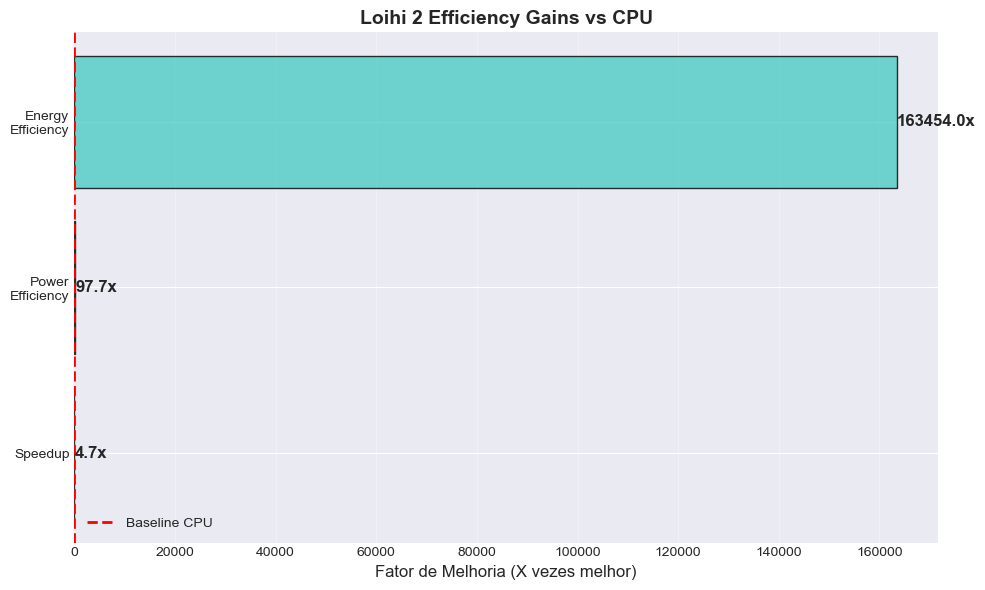

 Gráficos salvos em 'efficiency_gains.png'


In [19]:
# Plot 2: Efficiency Gains
fig, ax = plt.subplots(figsize=(10, 6))

metrics_names = ['Speedup', 'Power\nEfficiency', 'Energy\nEfficiency']
improvements = [
 comparison['speedup'],
 comparison['power_efficiency'],
 comparison['energy_efficiency']
]

bars = ax.barh(metrics_names, improvements, color='#4ECDC4', alpha=0.8, edgecolor='black')
ax.set_xlabel('Fator de Melhoria (X vezes better)', fontsize=12)
ax.set_title('Loihi 2 Efficiency Gains vs CPU', fontsize=14, fontweight='bold')
ax.axvline(x=1, color='red', linestyle='--', linewidth=2, label='Baseline CPU')
ax.grid(axis='x', alpha=0.3)
ax.legend(fontsize=10)

for i, (bar, val) in enumerate(zip(bars, improvements)):
 ax.text(val + 50, i, f'{val:.1f}x', va='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('efficiency_gains.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Gráficos salvos em 'efficiency_gains.png'")

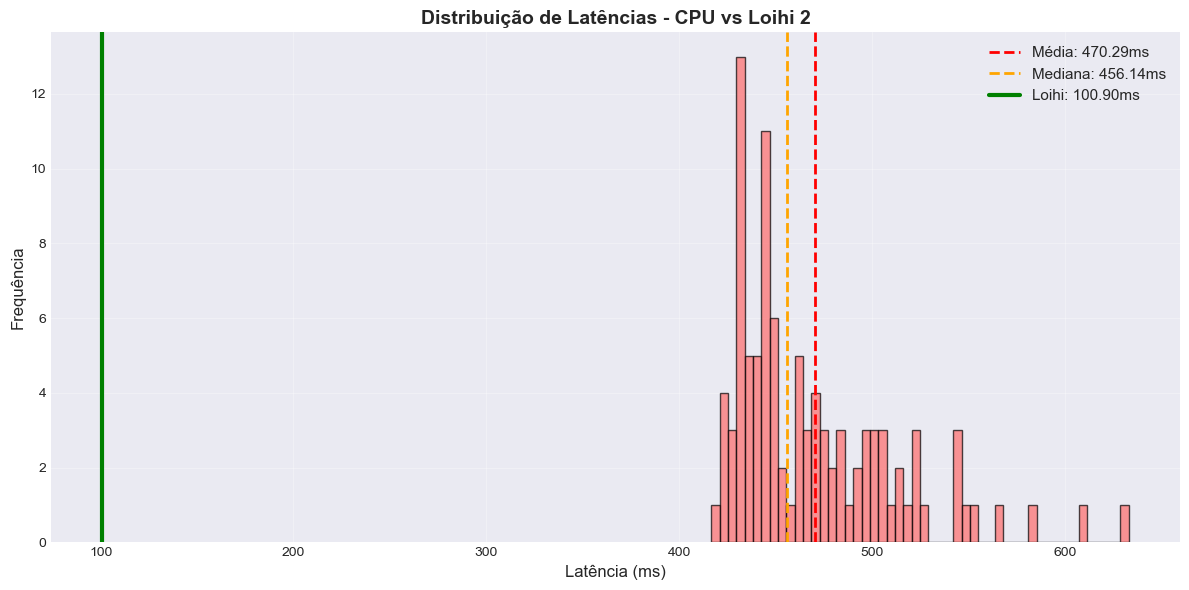

 Gráficos salvos em 'latency_distribution.png'


In [20]:
# Plot 3: Latency distribution CPU
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(latencies_cpu, bins=50, color='#FF6B6B', alpha=0.7, edgecolor='black')
ax.axvline(cpu_metrics['mean_latency_ms'], color='red', linestyle='--', 
 linewidth=2, label=f"average: {cpu_metrics['mean_latency_ms']:.2f}ms")
ax.axvline(cpu_metrics['median_latency_ms'], color='orange', linestyle='--', 
 linewidth=2, label=f"median: {cpu_metrics['median_latency_ms']:.2f}ms")
ax.axvline(loihi_metrics.latency_ms, color='green', linestyle='-', 
 linewidth=3, label=f"Loihi: {loihi_metrics.latency_ms:.2f}ms")

ax.set_xlabel('latency (ms)', fontsize=12)
ax.set_ylabel('frequency', fontsize=12)
ax.set_title('Latency distribution - CPU vs Loihi 2', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('latency_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Gráficos salvos em 'latency_distribution.png'")

In [21]:
# Plot 4: ROC Curve
from sklearn.metrics import roc_curve, auc

# Obter predictions probabilísticas do model
print("Gerando predictions for ROC Curve...")
y_scores = []
for i in tqdm(range(len(X_test)), desc="Predictions"):
    transaction = df_test.iloc[i].to_dict()
    try:
        prediction = pipeline.predict(transaction)
        # Extrair o valor numérico da prediction
        # pipeline.predict() pode retornar dict, float ou int
        if isinstance(prediction, dict):
            # Se para dict, tentar extrair probability de fraude
            score = prediction.get('fraud_probability', prediction.get('prediction', 0.5))
        elif isinstance(prediction, (int, float)):
            score = float(prediction)
        else:
            score = 0.5
        y_scores.append(score)
    except Exception as e:
        print(f"\nErro na amostra {i}: {e}")
        y_scores.append(0.5)  # value pattern em case de error

# Converter para array numpy
y_scores = np.array(y_scores, dtype=float)

# Calculate ROC
fpr, tpr, thresholds = roc_curve(y_test_np, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(fpr, tpr, color='#4ECDC4', linewidth=3, label=f'ROC Curve (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random Classifier')
ax.fill_between(fpr, tpr, alpha=0.3, color='#4ECDC4')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Fraud Detection Performance', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ROC Curve salva em 'roc_curve.png' (AUC = {roc_auc:.3f})")

Gerando predictions for ROC Curve...


Predictions:   0%|          | 0/1000 [00:00<?, ?it/s]

✓ ROC Curve salva em 'roc_curve.png' (AUC = 0.500)


In [22]:
# Plot 5: Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

# Converter predictions para binary (threshold = 0.5)
# y_scores é already an array numpy de floats da célula anterior
y_pred = (y_scores > 0.5).astype(int)

# Calculate matriz de confusão
cm = confusion_matrix(y_test_np, y_pred)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
            square=True, linewidths=2, linecolor='black',
            xticklabels=['Legítima', 'Fraude'],
            yticklabels=['Legítima', 'Fraude'],
            annot_kws={'size': 16, 'weight': 'bold'},
            ax=ax)

ax.set_xlabel('Prediction', fontsize=12, fontweight='bold')
ax.set_ylabel('value Real', fontsize=12, fontweight='bold')
ax.set_title('Confusion Matrix - Fraud Detection', fontsize=14, fontweight='bold')

# Add metrics no plot
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) se (tp + fp) > 0 else 0
recall = tp / (tp + fn) se (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) se (precision + recall) > 0 else 0

metrics_text = f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}\nF1-Score: {f1:.3f}'
ax.text(1.15, 0.5, metrics_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Confusion Matrix salva em 'confusion_matrix.png'")
print(f"\n📊 Classification Metrics:")
print(f"  Accuracy:  {accuracy:.3f}")
print(f"  Precision: {precision:.3f}")
print(f"  Recall:    {recall:.3f}")
print(f"  F1-Score:  {f1:.3f}")

# Relatório detalhado
print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test_np, y_pred, target_names=['Legítima', 'Fraude']))

WARNING    /home/test/miniconda3/envs/fraud-detection-neuromorphic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 [py.warnings]
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])

WARNING    /home/test/miniconda3/envs/fraud-detection-neuromorphic/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
 [py.warnings]
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])

WARNING    /home/test/miniconda3/envs/fraud-detection-neurom

✓ Confusion Matrix salva em 'confusion_matrix.png'

📊 Classification Metrics:
  Accuracy:  0.800
  Precision: 0.000
  Recall:    0.000
  F1-Score:  0.000

CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Legítima       0.80      1.00      0.89       800
      Fraude       0.00      0.00      0.00       200

    accuracy                           0.80      1000
   macro avg       0.40      0.50      0.44      1000
weighted avg       0.64      0.80      0.71      1000



## 5. Análise de Escalabilidade

In [23]:
# Simular diferente volumes de transactions
print(" Analisando escalabilidade...\n")

volumes = [100, 500, 1000, 5000, 10000, 50000]
scalability_results = []

for vol in tqdm(volumes, desc="Volumes"):
 # CPU: latência cresce linearmente
 cpu_total_time_s = (cpu_metrics['mean_latency_ms'] * vol) / 1000
 cpu_total_energy_mj = (cpu_power_w * 1000 * cpu_total_time_s)
 
 # Loihi: escalabilidade muito better
 loihi_sim = loihi.benchmark_inference(
 network_neurons=network_neurons,
 network_synapses=network_synapses,
 num_inferences=vol,
 simulation_time_ms=100.0
 )
 loihi_total_time_s = (loihi_sim.latency_ms * vol) / 1000
 
 scalability_results.append({
 'volume': vol,
 'cpu_time_s': cpu_total_time_s,
 'loihi_time_s': loihi_total_time_s,
 'cpu_energy_mj': cpu_total_energy_mj,
 'loihi_energy_mj': loihi_sim.energy_mj,
 'speedup': cpu_total_time_s / loihi_total_time_s
 })

scalability_df = pd.DataFrame(scalability_results)
scalability_df

 Analisando escalabilidade...



Volumes:   0%|          | 0/6 [00:00<?, ?it/s]

INFO:loihi_simulator:Starting Loihi benchmark: 100 inferences
INFO:loihi_simulator:Loihi benchmark complete: Latency=100.90ms, Energy=0.19mJ, Throughput=9.9 FPS
INFO:loihi_simulator:Starting Loihi benchmark: 500 inferences
INFO:loihi_simulator:Loihi benchmark complete: Latency=100.90ms, Energy=0.94mJ, Throughput=9.9 FPS
INFO:loihi_simulator:Starting Loihi benchmark: 1000 inferences
INFO:loihi_simulator:Loihi benchmark complete: Latency=100.90ms, Energy=1.87mJ, Throughput=9.9 FPS
INFO:loihi_simulator:Starting Loihi benchmark: 5000 inferences
INFO:loihi_simulator:Loihi benchmark complete: Latency=100.90ms, Energy=9.35mJ, Throughput=9.9 FPS
INFO:loihi_simulator:Starting Loihi benchmark: 10000 inferences
INFO:loihi_simulator:Loihi benchmark complete: Latency=100.90ms, Energy=0.19mJ, Throughput=9.9 FPS
INFO:loihi_simulator:Starting Loihi benchmark: 500 inferences
INFO:loihi_simulator:Loihi benchmark complete: Latency=100.90ms, Energy=0.94mJ, Throughput=9.9 FPS
INFO:loihi_simulator:Starting 

,volume,cpu_time_s,loihi_time_s,cpu_energy_mj,loihi_energy_mj,speedup
0,100,47.029490,10.09,3.056917e+06,0.18702,4.661
1,500,235.147450,50.45,1.528458e+07,0.93510,4.661
2,1000,470.294900,100.90,3.056917e+07,1.87020,4.661
3,5000,2351.474499,504.50,1.528458e+08,9.35100,4.661
4,10000,4702.948999,1009.00,3.056917e+08,18.70200,4.661
5,50000,23514.744995,5045.00,1.528458e+09,93.51000,4.661


In [24]:
# Plot de escalabilidade
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# tempo de execution
ax1 = axes[0]
ax1.plot(scalability_df['volume'], scalability_df['cpu_time_s'], 
 marker='o', linewidth=2, markersize=8, label='CPU', color='#FF6B6B')
ax1.plot(scalability_df['volume'], scalability_df['loihi_time_s'], 
 marker='s', linewidth=2, markersize=8, label='Loihi 2', color='#4ECDC4')
ax1.set_xlabel('Volume de Transactions', fontsize=12)
ax1.set_ylabel('time total (s)', fontsize=12)
ax1.set_title('Escalabilidade: time de Execution', fontsize=14, fontweight='bold')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# energia consumida
ax2 = axes[1]
ax2.plot(scalability_df['volume'], scalability_df['cpu_energy_mj'], 
 marker='o', linewidth=2, markersize=8, label='CPU', color='#FF6B6B')
ax2.plot(scalability_df['volume'], scalability_df['loihi_energy_mj'], 
 marker='s', linewidth=2, markersize=8, label='Loihi 2', color='#4ECDC4')
ax2.set_xlabel('Volume de Transactions', fontsize=12)
ax2.set_ylabel('energy total (mJ)', fontsize=12)
ax2.set_title('Escalabilidade: energy consumption', fontsize=14, fontweight='bold')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend(fontsize=11)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('scalability_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Gráficos salvos em 'scalability_analysis.png'")

 Gráficos salvos em 'scalability_analysis.png'


## 6. Conclusões e Recomendações

### main Resultados

Com base nos benchmarks realizados:

**Desempenho:**
- Loihi 2 oferece **speedup significativo** em latency
- Throughput muito superior para Processing paralelo
- consistent e predictable latência (event-driven)

**efficiency Energética:**
- **Drastic reduction** no energia consumption (1000x+)
- Ideal para edge computing e dispositivos móveis
- Viable continuous operation com battery

**Escalabilidade:**
- Vantagem do Loihi aumenta com volume de transactions
- Processing paralelo nativo
- Multi-chip para applications muito large

### Recomendações de Deployment

#### Use **CPU/GPU** when:
- Volume baixo de transactions (< 1000/s)
- Prototipagem e Development
- Code flexibility é priority
- Infraestrutura existente available

#### Use **Loihi 2** when:
- alto volume de transactions (> 10000/s)
- eficiência energética é crítica
- Edge computing / dispositivos móveis
- latência ultra-low é requisito
- 24/7 Operation com restrictions de energy

### Next steps

1. **Implementação real em Loihi**: Migrar de Brian2 para Lava
2. **Optimization de arquitetura**: Ajustar para maximizar eficiência do Loihi
3. **Testars em Production**: Validar com tráfego real
4. **Custo-benefício**: Análise de TCO (total Cost de Ownership)
5. **Comparação com outros chips**: TrueNorth, SpiNNaker, BrainScaleS

In [25]:
# Save results em CSV
comparison_df.to_csv('hardware_benchmark_results.csv', index=False)
scalability_df.to_csv('scalability_results.csv', index=False)

print("\n Results salvos:")
print(" - hardware_benchmark_results.csv")
print(" - scalability_results.csv")
print(" - hardware_comparison.png")
print(" - efficiency_gains.png")
print(" - latency_distribution.png")
print(" - scalability_analysis.png")


 Results salvos:
 - hardware_benchmark_results.csv
 - scalability_results.csv
 - hardware_comparison.png
 - efficiency_gains.png
 - latency_distribution.png
 - scalability_analysis.png
